<a href="https://colab.research.google.com/github/mar2nyuedu/colab/blob/main/ddos_attack_detection_Tom_Murphy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [244]:
import pandas as pd
import numpy as np
import warnings
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
from sklearn import metrics
from sklearn import metrics

In [245]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [246]:
data = pd.read_csv('/content/drive/MyDrive/Project/dataset_sdn.csv')
#shuffle
#data = data.sample(frac=1)

In [247]:
data.head()

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,...,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,...,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,3,3413,3665,0,0.0,0.0,0


In [248]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104345 entries, 0 to 104344
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt           104345 non-null  int64  
 1   switch       104345 non-null  int64  
 2   src          104345 non-null  object 
 3   dst          104345 non-null  object 
 4   pktcount     104345 non-null  int64  
 5   bytecount    104345 non-null  int64  
 6   dur          104345 non-null  int64  
 7   dur_nsec     104345 non-null  int64  
 8   tot_dur      104345 non-null  float64
 9   flows        104345 non-null  int64  
 10  packetins    104345 non-null  int64  
 11  pktperflow   104345 non-null  int64  
 12  byteperflow  104345 non-null  int64  
 13  pktrate      104345 non-null  int64  
 14  Pairflow     104345 non-null  int64  
 15  Protocol     104345 non-null  object 
 16  port_no      104345 non-null  int64  
 17  tx_bytes     104345 non-null  int64  
 18  rx_bytes     104345 non-

In [249]:
data.label.value_counts()

0    63561
1    40784
Name: label, dtype: int64

In [250]:
data.isnull().sum()

dt               0
switch           0
src              0
dst              0
pktcount         0
bytecount        0
dur              0
dur_nsec         0
tot_dur          0
flows            0
packetins        0
pktperflow       0
byteperflow      0
pktrate          0
Pairflow         0
Protocol         0
port_no          0
tx_bytes         0
rx_bytes         0
tx_kbps          0
rx_kbps        506
tot_kbps       506
label            0
dtype: int64

In [251]:
# Replace nulls with zeros
data.fillna(0, inplace=True)

In [252]:
data.isnull().sum()

dt             0
switch         0
src            0
dst            0
pktcount       0
bytecount      0
dur            0
dur_nsec       0
tot_dur        0
flows          0
packetins      0
pktperflow     0
byteperflow    0
pktrate        0
Pairflow       0
Protocol       0
port_no        0
tx_bytes       0
rx_bytes       0
tx_kbps        0
rx_kbps        0
tot_kbps       0
label          0
dtype: int64

In [253]:
duplicates = data.duplicated()
duplicate_rows = duplicates.sum()
# Print the results
print("Number of duplicate rows:", duplicate_rows)

Number of duplicate rows: 5091


In [254]:
# Remove duplicate rows
data.drop_duplicates(inplace=True)

In [255]:
duplicates = data.duplicated()
duplicate_rows = duplicates.sum()
# Print the results
print("Number of duplicate rows:", duplicate_rows)

Number of duplicate rows: 0


In [256]:
corr_matrix = data.corr()

threshold = 0.99
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

for corr in high_corr:
    print(f"{corr[0]} and {corr[1]}: {corr[2]}")

tot_dur and dur: 0.9999983911151613
pktrate and pktperflow: 0.9999988531120457


In [257]:
#delete high correlation data
#data.drop('column_name', axis=1, inplace=True)

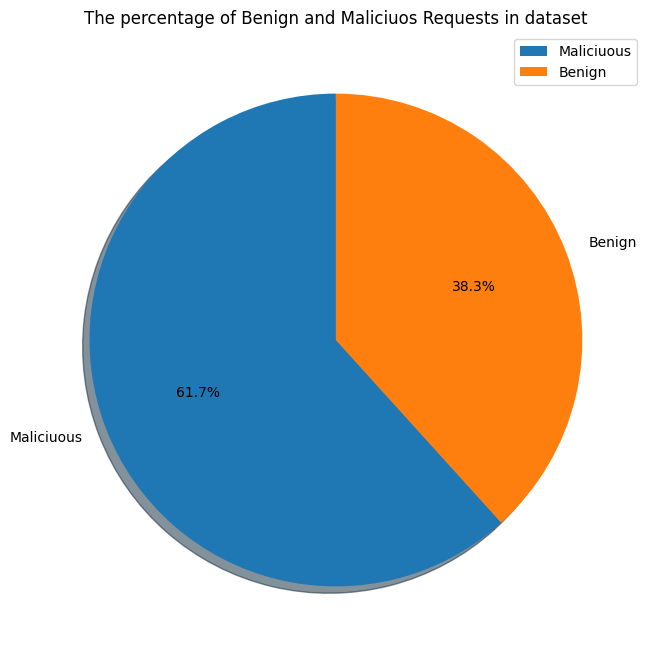

In [258]:
labels = ["Maliciuous",'Benign']
sizes = [dict(data.label.value_counts())[0], dict(data.label.value_counts())[1]]
plt.figure(figsize = (13,8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.legend(["Maliciuous", "Benign"])
plt.title('The percentage of Benign and Maliciuos Requests in dataset')
plt.show()

In [259]:
#### Let's  find out object columns

object_df = data.select_dtypes(include=['object'])
object_cols = object_df.columns
print('Object Columns: ')
print(object_cols, '\n')
print('Number of Object Features: ', len(object_cols))

Object Columns: 
Index(['src', 'dst', 'Protocol'], dtype='object') 

Number of Object Features:  3


In [260]:
object_df.head()

,src,dst,Protocol
0,10.0.0.1,10.0.0.8,UDP
1,10.0.0.1,10.0.0.8,UDP
2,10.0.0.2,10.0.0.8,UDP
3,10.0.0.2,10.0.0.8,UDP
4,10.0.0.2,10.0.0.8,UDP


In [261]:
print(sorted(data['Protocol'].unique()))
print(data['Protocol'].nunique())
print(sorted(data['src'].unique()))
print("Sources: ", data['src'].nunique())
print(sorted(data['dst'].unique()))
print("Destinations: ",data['dst'].nunique())

['ICMP', 'TCP', 'UDP']
3
['10.0.0.1', '10.0.0.10', '10.0.0.11', '10.0.0.12', '10.0.0.13', '10.0.0.14', '10.0.0.15', '10.0.0.16', '10.0.0.17', '10.0.0.18', '10.0.0.2', '10.0.0.20', '10.0.0.3', '10.0.0.4', '10.0.0.5', '10.0.0.6', '10.0.0.7', '10.0.0.8', '10.0.0.9']
Sources:  19
['10.0.0.1', '10.0.0.10', '10.0.0.11', '10.0.0.12', '10.0.0.13', '10.0.0.14', '10.0.0.15', '10.0.0.16', '10.0.0.17', '10.0.0.18', '10.0.0.2', '10.0.0.3', '10.0.0.4', '10.0.0.5', '10.0.0.6', '10.0.0.7', '10.0.0.8', '10.0.0.9']
Destinations:  18


In [262]:
# convert string values to numeric 
le=preprocessing.LabelEncoder()
clm=['Protocol', 'src', 'dst']
for x in clm:
    data[x]=le.fit_transform(data[x])

In [263]:
print(sorted(data['Protocol'].unique()))
print(data['Protocol'].nunique())
print(sorted(data['src'].unique()))
print("Sources: ", data['src'].nunique())
print(sorted(data['dst'].unique()))
print("Destinations: ",data['dst'].nunique())

[0, 1, 2]
3
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Sources:  19
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Destinations:  18


In [264]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99254 entries, 0 to 104344
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   dt           99254 non-null  int64  
 1   switch       99254 non-null  int64  
 2   src          99254 non-null  int64  
 3   dst          99254 non-null  int64  
 4   pktcount     99254 non-null  int64  
 5   bytecount    99254 non-null  int64  
 6   dur          99254 non-null  int64  
 7   dur_nsec     99254 non-null  int64  
 8   tot_dur      99254 non-null  float64
 9   flows        99254 non-null  int64  
 10  packetins    99254 non-null  int64  
 11  pktperflow   99254 non-null  int64  
 12  byteperflow  99254 non-null  int64  
 13  pktrate      99254 non-null  int64  
 14  Pairflow     99254 non-null  int64  
 15  Protocol     99254 non-null  int64  
 16  port_no      99254 non-null  int64  
 17  tx_bytes     99254 non-null  int64  
 18  rx_bytes     99254 non-null  int64  
 19  tx_

In [265]:
# Split the dataset into training and test sets
df_train, df_test = train_test_split(data, test_size=0.2)

# Print the sizes of the training and test sets
print('Training set size:', len(df_train))
print('Test set size:', len(df_test))

Training set size: 79403
Test set size: 19851


In [266]:
df_train.head(5)

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
19842,2889,1,13,11,99811,104003062,357,486000000,3.570000e+11,2,...,273,0,2,1,4033,1312,0,0.0,0.0,1
83656,4217,3,17,12,115151,127836350,261,167000000,2.610000e+11,11,...,449,1,1,2,1992955,1852726,144,134.0,278.0,0
77817,42215,5,14,7,56293,3264994,194,86000000,1.940000e+11,5,...,294,1,1,1,6218729,146106820,156,3513.0,3669.0,1
3618,9876,2,0,15,19494,20780604,42,894000000,4.289400e+10,3,...,450,0,2,1,213114126,1676,14176,0.0,14176.0,0
63659,29682,4,3,15,810,79380,830,237000000,8.300000e+11,11,...,0,1,0,3,96194,135556026,1,1.0,2.0,0


In [267]:
x_train=df_train.drop('label',axis=1)
x_train.head(5)


,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,byteperflow,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps
19842,2889,1,13,11,99811,104003062,357,486000000,3.570000e+11,2,...,8561072,273,0,2,1,4033,1312,0,0.0,0.0
83656,4217,3,17,12,115151,127836350,261,167000000,2.610000e+11,11,...,14738784,449,1,1,2,1992955,1852726,144,134.0,278.0
77817,42215,5,14,7,56293,3264994,194,86000000,1.940000e+11,5,...,512836,294,1,1,1,6218729,146106820,156,3513.0,3669.0
3618,9876,2,0,15,19494,20780604,42,894000000,4.289400e+10,3,...,14419782,450,0,2,1,213114126,1676,14176,0.0,14176.0
63659,29682,4,3,15,810,79380,830,237000000,8.300000e+11,11,...,2842,0,1,0,3,96194,135556026,1,1.0,2.0


In [268]:
y_train=df_train["label"]
y_train.head(5)


19842    1
83656    0
77817    1
3618     0
63659    0
Name: label, dtype: int64

In [269]:
df_test.head(5)

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
60844,34413,3,16,13,603,59094,618,227000000,6.180000e+11,5,...,0,1,0,1,271344800,135981050,1,1.0,2.0,0
47841,27167,1,0,15,372,36456,381,190000000,3.810000e+11,4,...,1,1,0,2,133081390,1942,2485,0.0,2485.0,0
25000,3399,3,18,13,133535,142348310,293,981000000,2.940000e+11,5,...,451,0,2,1,3660,4178,0,0.0,0.0,0
82464,15725,3,10,16,37531,2026674,68,745000000,6.874500e+10,5,...,567,1,1,2,1470003,33946384,168,3921.0,4089.0,1
71126,7297,9,5,15,106597,5756238,361,193000000,3.610000e+11,5,...,279,1,1,1,6504125,5904218,129,120.0,249.0,1


In [270]:
x_test=df_test.drop('label',axis=1)
x_test.head(5)


,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,byteperflow,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps
60844,34413,3,16,13,603,59094,618,227000000,6.180000e+11,5,...,2842,0,1,0,1,271344800,135981050,1,1.0,2.0
47841,27167,1,0,15,372,36456,381,190000000,3.810000e+11,4,...,2940,1,1,0,2,133081390,1942,2485,0.0,2485.0
25000,3399,3,18,13,133535,142348310,293,981000000,2.940000e+11,5,...,14426178,451,0,2,1,3660,4178,0,0.0,0.0
82464,15725,3,10,16,37531,2026674,68,745000000,6.874500e+10,5,...,919026,567,1,1,2,1470003,33946384,168,3921.0,4089.0
71126,7297,9,5,15,106597,5756238,361,193000000,3.610000e+11,5,...,453384,279,1,1,1,6504125,5904218,129,120.0,249.0


In [271]:
y_test=df_test["label"]
y_test.head(5)

60844    0
47841    0
25000    0
82464    1
71126    1
Name: label, dtype: int64

In [272]:
scaler = MinMaxScaler()
x_train= scaler.fit_transform(x_train)
x_test= scaler.fit_transform(x_test)


In [273]:
lr = LogisticRegression(max_iter=1000, solver='lbfgs')
lr.fit(x_train, y_train)
# Make predictions
predictions = lr.predict(x_test)
confusion = confusion_matrix(y_test,predictions)
tn, fp, fn, tp = confusion.ravel()
print("True Positive: ", tp)
print("False Positive: ", fp)
print("True Negative: ", tn)
print("False Negative: ", fn)
accuracy = round(accuracy_score(predictions, y_test)*100,2)
print("Accuracy", accuracy)

True Positive:  4784
False Positive:  1920
True Negative:  10329
False Negative:  2818
Accuracy 76.13


In [274]:
dt = DecisionTreeClassifier(max_depth=20)
dt.fit(x_train, y_train)
# Make predictions
predictions = dt.predict(x_test)
confusion = confusion_matrix(y_test,predictions)
tn, fp, fn, tp = confusion.ravel()
print("True Positive: ", tp)
print("False Positive: ", fp)
print("True Negative: ", tn)
print("False Negative: ", fn)
accuracy = round(accuracy_score(predictions, y_test)*100,2)
print("Accuracy", accuracy)

True Positive:  7602
False Positive:  3
True Negative:  12246
False Negative:  0
Accuracy 99.98
